<a href="https://colab.research.google.com/github/bretmorin/EV-Machine-Learning/blob/main/EV_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing Tools

## Importing the libraries

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

## Importing the dataset

In [55]:
# Import dataset file
dataset = pd.read_csv('NRELs Charging Data - Raw.csv')

# Matrix of features, excluding the dependent variable column of 'expected_departure'
X = dataset.drop('expected_departure', axis=1).values

# Dependent variable column 'expected_departure' only
y = dataset['expected_departure'].values

## Resolving missing data

To find missing/Null data and resolve

In [56]:
# Change Null values in 'vehicle_model' to 'Other'; 7579 total
dataset['vehicle_model'].fillna('Other', inplace=True)

# To make sure X is updated with the new values
X = dataset.drop('expected_departure', axis=1).values

In [57]:
#------Resolve Null values in 'start_date_time' and 'end_date_time'; 26,390 total, each------#

# Convert columns to datetime objects; 'errors='coerce' to handle values that can't convert
dataset['start_date_time'] = pd.to_datetime(dataset['start_date_time'], errors='coerce')
dataset['end_date_time'] = pd.to_datetime(dataset['end_date_time'], errors='coerce')
dataset['start_charge'] = pd.to_datetime(dataset['start_charge'], errors='coerce')
dataset['termin_charge'] = pd.to_datetime(dataset['termin_charge'], errors='coerce')

# Drop rows where both 'start_date_time' and 'end_date_time' are missing
dataset = dataset.dropna(subset=['start_date_time', 'end_date_time'])

# Reset the index after dropping rows
dataset.reset_index(drop=True, inplace=True)

# Drop rows where both 'start_charge' and 'termin_charge' are missing
dataset = dataset.dropna(subset=['start_charge', 'termin_charge'])

# Reset the index after dropping rows
dataset.reset_index(drop=True, inplace=True)

In [58]:
# Resolve erroneous values in 'miles_requested'
neg_miles = dataset[(dataset['miles_requested'] < 1)].index

# Replace negative values with the mean of the remaining values in the column
dataset.loc[neg_miles, 'miles_requested'] = dataset['miles_requested'].mean()

# Sort by 'miles_requested' to verify it worked
sorted_dataset = dataset.sort_values(by='miles_requested')

In [59]:
# Resolve erroneous values in 'kwh_requested'
neg_kwh = dataset[(dataset['kwh_requested'] < .01)].index

# Replace negative values with the mean of the remaining values in the column
dataset.loc[neg_kwh, 'kwh_requested'] = dataset['kwh_requested'].mean()

# Sort by 'kwh_requested' to verify it worked
sorted_dataset_2 = dataset.sort_values(by='kwh_requested')

In [60]:
#------Resolve Null values in 'max_charge_power' and 'energy_charged'; 486 total, each------#

# Resolve erroneous values in 'energy_charged'
zero_energy = dataset[dataset['energy_charged'] < 0.001].index

# Add a small constant to all 'energy_charged' values to avoid being 0
small_constant = 0.001
dataset['energy_charged'] = dataset['energy_charged'].apply(lambda x: x + small_constant if x < 0.001 else x)

# Replace negative values with the mean of the remaining values in the column
dataset.loc[zero_energy, 'energy_charged'] = dataset['energy_charged'].mean()

# Calculate the mean
max_charge_power_mean = dataset['max_charge_power'].mean()
energy_charged_mean = dataset['energy_charged'].mean()

# Fill null values with the mean
dataset['max_charge_power'].fillna(max_charge_power_mean, inplace=True)
dataset['energy_charged'].fillna(energy_charged_mean, inplace=True)

# Sort by 'energy_charged' to verify it worked
sorted_dataset_3 = dataset.sort_values(by='max_charge_power')

In [61]:
# Drop irrelevant columns
dataset.drop(['driverId', 'station', 'controlled_duration', 'cost_for_session', 'afterPaid'], axis=1, inplace=True)

### Creation of new columns to see differences in column data

In [62]:
#------Create column for comparing the request entry time vs the expected departure time------#

# Convert 'expected_departure' and 'request_entry_time' columns to datetime
dataset['expected_departure'] = pd.to_datetime(dataset['expected_departure'])
dataset['request_entry_time'] = pd.to_datetime(dataset['request_entry_time'])

# Create column for time difference(in seconds) between 'expected_departure' and 'request_entry_time'
dataset['request_duration'] = (dataset['expected_departure'] - dataset['request_entry_time'])

# Convert to timedelta
dataset['request_duration'] = pd.to_timedelta(dataset['request_duration'], unit='s').round('1s')

In [63]:
#------Create column for comparing the terminated charge time vs the start charge time------#

# Convert 'start_charge' and 'termin_charge' columns to datetime
dataset['termin_charge'] = pd.to_datetime(dataset['termin_charge'])
dataset['start_charge'] = pd.to_datetime(dataset['start_charge'])

# Create column for time difference(in seconds) between 'start_charge' and 'termin_charge'
dataset['charge_duration'] = (dataset['termin_charge'] - dataset['start_charge']).dt.total_seconds()

# Convert to timedelta
dataset['charge_duration'] = pd.to_timedelta(dataset['charge_duration'], unit='s').round('1s')

In [64]:
#------Create column for comparing the charge time vs the expected duration------#

# Convert 'expected_departure' and 'request_entry_time' columns to datetime
dataset['expected_departure'] = pd.to_datetime(dataset['expected_departure'])
dataset['request_entry_time'] = pd.to_datetime(dataset['request_entry_time'])

# Create 'expected_duration', assuming 'expected_departure' and 'request_entry_time' are datetime columns
dataset['expected_duration'] = (dataset['expected_departure'] - dataset['request_entry_time']).dt.total_seconds()

# Convert 'charge_duration' to total seconds
dataset['charge_duration_seconds'] = dataset['charge_duration'].dt.total_seconds()

# Calculate the difference between 'charge_duration' and 'expected_duration'
dataset['charge_vs_expected_diff'] = dataset['expected_duration'] - dataset['charge_duration_seconds']

# Convert to timedelta
dataset['charge_vs_expected_diff'] = pd.to_timedelta(dataset['charge_vs_expected_diff'], unit='s').round('1s')

In [65]:
#------Create column for calculating miles per hour based on requested miles vs actual charge duration------#

# Set a minimum threshold for charge duration
min_charge_duration_threshold = pd.Timedelta(minutes=5)

# Calculate 'miles_per_hour'
dataset['miles_per_hour'] = (dataset['miles_requested'] / (dataset['charge_duration'].dt.total_seconds() / 3600)).round(2)

# Filter out cases with charge duration below the threshold
dataset = dataset[dataset['charge_duration'] >= min_charge_duration_threshold]

# Remove rows with infinite or NaN values in 'miles_per_hour'
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna(subset=['miles_per_hour'])

In [66]:
print(dataset[['request_duration', 'charge_duration']])
print(dataset[['charge_vs_expected_diff', 'expected_duration', 'request_entry_time']])
print(dataset['miles_per_hour'])

      request_duration charge_duration
0      0 days 09:33:00 0 days 00:06:17
1      0 days 07:37:00 0 days 03:31:13
2      0 days 07:37:00 0 days 02:51:46
3      0 days 09:37:00 0 days 05:14:52
4      0 days 08:56:00 0 days 02:33:29
...                ...             ...
10696  0 days 08:00:05 0 days 02:28:02
10697  0 days 04:00:57 0 days 02:19:22
10698  0 days 04:00:00 0 days 01:54:56
10699  0 days 05:48:07 0 days 02:58:22
10700  0 days 08:00:16 0 days 03:28:36

[10587 rows x 2 columns]
      charge_vs_expected_diff  expected_duration  request_entry_time
0             0 days 09:26:43            34380.0 2019-08-29 08:34:59
1             0 days 04:05:47            27420.0 2019-09-01 09:58:42
2             0 days 04:45:14            27420.0 2019-09-02 08:29:54
3             0 days 04:22:08            34620.0 2019-09-03 06:29:11
4             0 days 06:22:31            32160.0 2019-09-03 06:32:01
...                       ...                ...                 ...
10696         0 days 05

# Encoding categorical data

## Encoding the Independent Variables

In [67]:
print(dataset)

       vehicle_model  request_entry_time  expected_departure  \
0              Other 2019-08-29 08:34:59 2019-08-29 18:07:59   
1        Nissan LEAF 2019-09-01 09:58:42 2019-09-01 17:35:42   
2        Nissan LEAF 2019-09-02 08:29:54 2019-09-02 16:06:54   
3      Tesla Model 3 2019-09-03 06:29:11 2019-09-03 16:06:11   
4              Other 2019-09-03 06:32:01 2019-09-03 15:28:01   
...              ...                 ...                 ...   
10696          Other 2021-10-11 08:38:00 2021-10-11 16:38:05   
10697    Chevy Spark 2021-10-11 11:22:00 2021-10-11 15:22:57   
10698          Other 2021-10-11 13:28:00 2021-10-11 17:28:00   
10699          Other 2021-10-11 13:44:00 2021-10-11 19:32:07   
10700    Nissan LEAF 2021-10-11 13:54:00 2021-10-11 21:54:16   

          start_date_time       end_date_time        start_charge  \
0     2019-08-29 08:35:55 2019-09-03 18:37:11 2019-09-03 13:21:37   
1     2019-09-01 09:59:19 2019-09-01 17:44:22 2019-09-01 09:59:38   
2     2019-09-02 08:30:2

In [68]:
# Apply one-hot encoding to the 'vehicle_model' column
dataset = pd.get_dummies(dataset, columns=['vehicle_model'], prefix='vehicle')

# Extract datetime features to capture time of day patterns
dataset['day_of_week'] = dataset['request_entry_time'].dt.dayofweek
dataset['hour_of_day'] = dataset['request_entry_time'].dt.hour

In [69]:
# Winsorize 'miles_per_hour'
from scipy.stats.mstats import winsorize

# Percentage limits for winsorization
lower_limit = 0.0001  # 0.01%
upper_limit = 0.0001   # 0.01%

# Winsorize the 'miles_per_hour' column
winsorized_miles_per_hour = winsorize(dataset['miles_per_hour'], limits=(lower_limit, upper_limit))

# Replace the original 'miles_per_hour' column with the winsorized values
dataset['miles_per_hour'] = winsorized_miles_per_hour

In [70]:
#------This removes a small amount of outliers------#

# Define a threshold to consider data points as outliers
outlier_threshold = 400

# Filter out rows with 'miles_per_hour' greater than the threshold
dataset = dataset[dataset['miles_per_hour'] <= outlier_threshold]

## Encoding the Dependent Variable

Since the dependent variable is 'expected_duration', it doesn't need to be encoded as it is already in numerical form.

## Exploratory Data Analysis

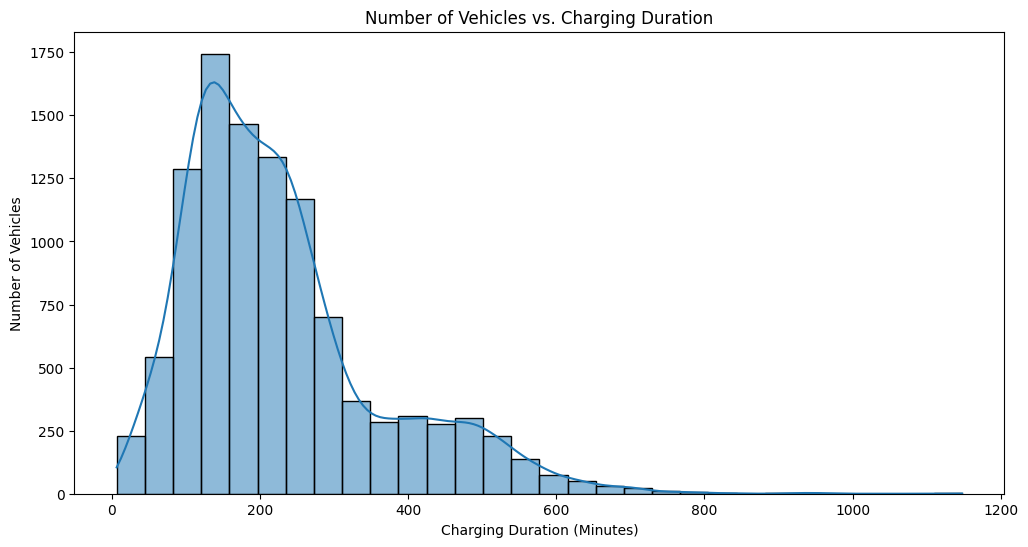

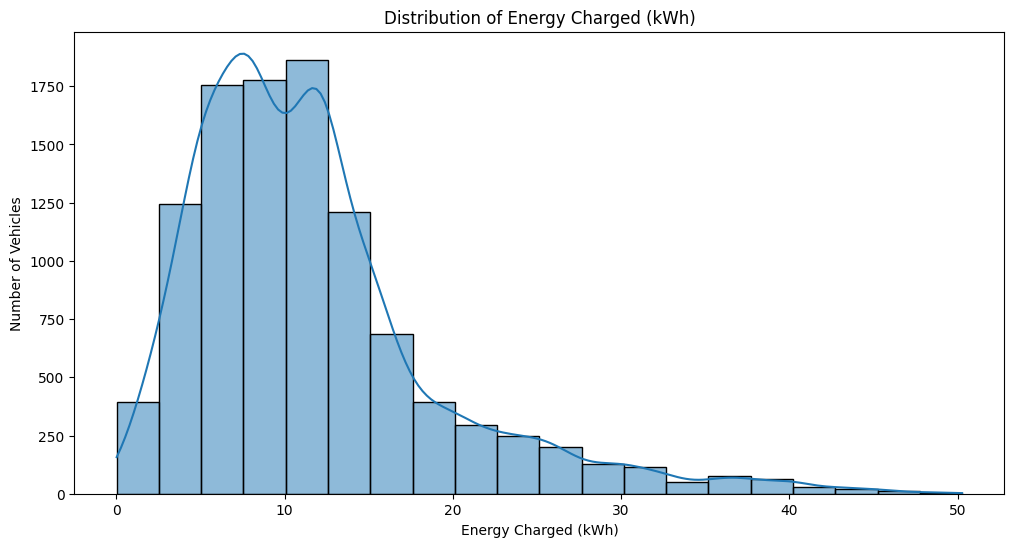

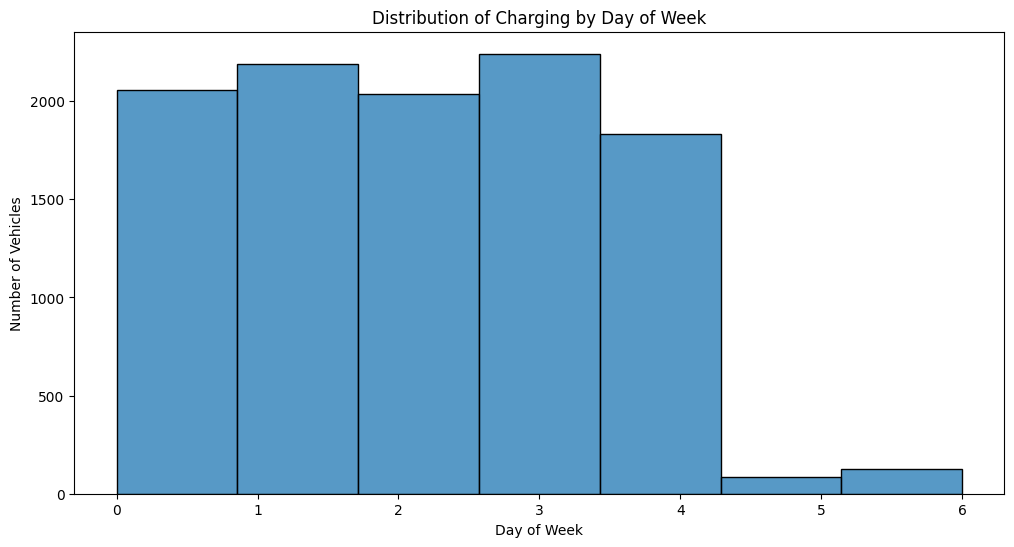

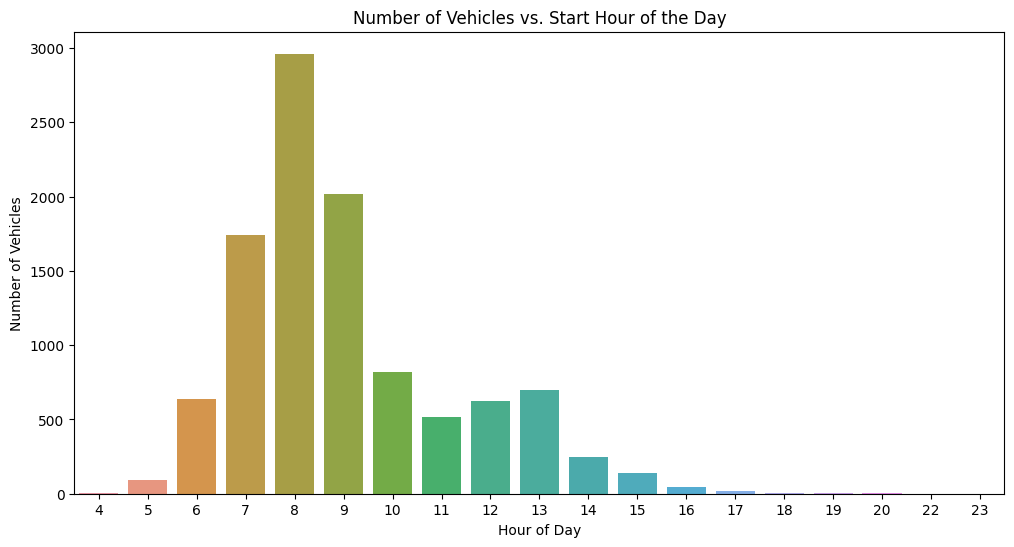

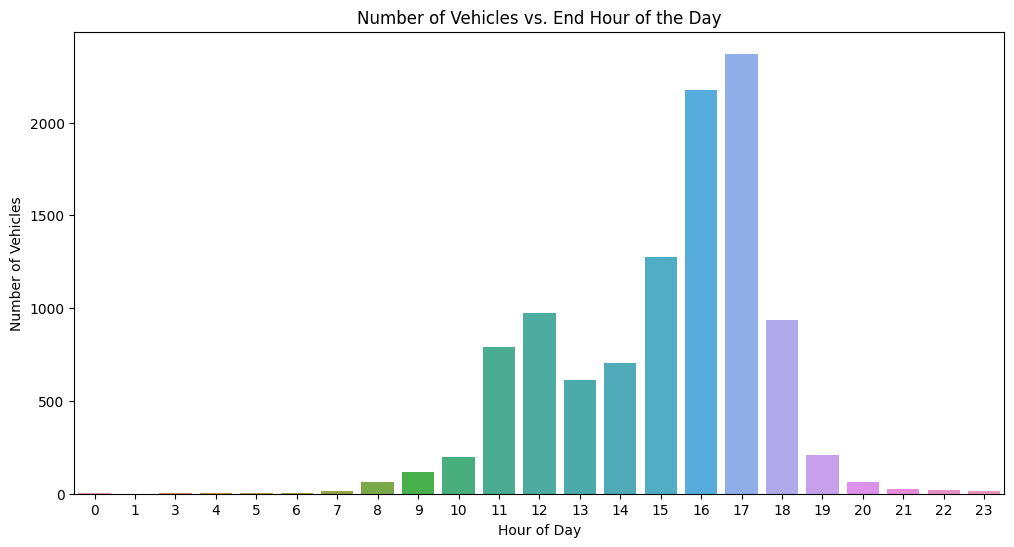

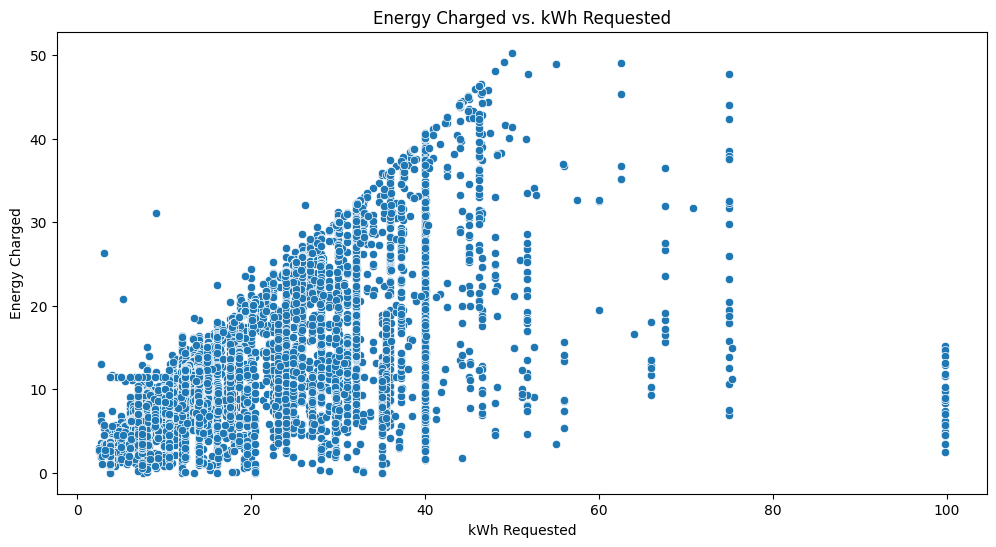

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of Vehicles vs. Charging Duration
plt.figure(figsize=(12, 6))
sns.histplot(dataset['charge_duration'].dt.total_seconds() / 60, bins=30, kde=True)
plt.title('Number of Vehicles vs. Charging Duration')
plt.xlabel('Charging Duration (Minutes)')
plt.ylabel('Number of Vehicles')
plt.show()

# Number of Vehicles vs. Energy Charged (kWh)
plt.figure(figsize=(12, 6))
sns.histplot(dataset['energy_charged'], bins=20, kde=True)
plt.title('Distribution of Energy Charged (kWh)')
plt.xlabel('Energy Charged (kWh)')
plt.ylabel('Number of Vehicles')
plt.show()

# Number of Vehicles vs. Day of the Week
plt.figure(figsize=(12, 6))
sns.histplot(dataset['day_of_week'], bins=7, kde=False)
plt.title('Distribution of Charging by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Vehicles')
plt.show()

# Number of Vehicles vs. Start Hour of the Day
plt.figure(figsize=(12, 6))
sns.countplot(x=dataset['start_date_time'].dt.hour)
plt.title('Number of Vehicles vs. Start Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Vehicles')
plt.show()

# Number of Vehicles vs. End Hour of the Day
plt.figure(figsize=(12, 6))
sns.countplot(x=dataset['end_date_time'].dt.hour)
plt.title('Number of Vehicles vs. End Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Vehicles')
plt.show()

# Energy Charged vs. kWh Requested
plt.figure(figsize=(12, 6))
sns.scatterplot(x='kwh_requested', y='energy_charged', data=dataset)
plt.title('Energy Charged vs. kWh Requested')
plt.xlabel('kWh Requested')
plt.ylabel('Energy Charged')
plt.show()

## Splitting the dataset and training it with Random Forest Classification Model

In [72]:
# Convert seconds to minutes
dataset['charge_duration_minutes'] = dataset['charge_duration_seconds'] / 60

# Define duration categories
conditions = [
    (dataset['charge_duration_minutes'] < 150),
    (dataset['charge_duration_minutes'] >= 150) & (dataset['charge_duration_minutes'] <= 250),
    (dataset['charge_duration_minutes'] > 250)
]

# Define category labels
labels = ['short', 'medium', 'long']

# Create new categorical column in the dataset
dataset['duration_category'] = np.select(conditions, labels)

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Selected model features
features = dataset[['miles_requested', 'max_charge_power', 'kwh_requested', 'energy_charged', 'day_of_week', 'hour_of_day']]
target = dataset['duration_category']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest Classification Model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the Model
predictions = rf_classifier.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        long       0.78      0.73      0.75       672
      medium       0.72      0.68      0.70       728
       short       0.77      0.85      0.81       716

    accuracy                           0.75      2116
   macro avg       0.75      0.75      0.75      2116
weighted avg       0.75      0.75      0.75      2116

